In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import matplotlib.ticker as ticker
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.BoundaryShape import *
import matplotlib.patches as mpatches
from PDE2D import PATH

In [2]:
def disable_ticks(ax):
    """Disable ticks around plot (useful for displaying images)"""
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

def disable_ticks_y(ax):
    """Disable ticks around plot (useful for displaying images)"""
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])

def disable_border(ax):
    """Disable border around plot"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


In [3]:
resolution_plot = [1024, 1024]
redistance = False
opt_type = "circle"
skip = "skip2"
set = f"{PATH}/output2D/optimizations/discrete-eit"
sdf_res = 64
dist_der = 0.03
conf_per_iter = 4
delta = True
bg = 0
normalized = False
spe = 15
normal_spp = 16
cond_bar = bg > 0

conf_per_iter 
config1 = f"config1-{skip}"
config2 = f"config2-{skip}"
config3 = f"config3-{skip}"
config4 = f"config4-{skip}"
folder1 = f"distder{dist_der}-confperiter{conf_per_iter}"
folder2 = f"spe{spe}-normalspp{normal_spp}"
path1 = os.path.join(set, opt_type, config1, folder1, folder2)
path2 = os.path.join(set, opt_type, config2, folder1, folder2)
path3 = os.path.join(set, opt_type, config3, folder1, folder2)
path4 = os.path.join(set, opt_type, config4, folder1, folder2)
path1_npy = os.path.join(path1, "record.npy")
path2_npy = os.path.join(path2, "record.npy")
path3_npy = os.path.join(path3, "record.npy")
path4_npy = os.path.join(path4, "record.npy")
path_obj1 = os.path.join(set, "objectives", opt_type, config1)
path_obj2 = os.path.join(set, "objectives", opt_type, config2)
path_obj3 = os.path.join(set, "objectives", opt_type, config3)
path_obj4 = os.path.join(set, "objectives", opt_type, config4)

In [4]:
record1 = np.load(path1_npy, allow_pickle=True).item()
record2 = np.load(path2_npy, allow_pickle=True).item()
record3 = np.load(path3_npy, allow_pickle=True).item()
record4 = np.load(path4_npy, allow_pickle=True).item()

In [5]:
DEFAULT_FONTSIZE = 5.7  # Font size used by captions in ACM format
DEFAULT_FONTSIZE_SMALL = 5.7

MPL_STYLE = {
    "text.usetex": True,
    "text.color": 'black',
    "font.size": DEFAULT_FONTSIZE,
    "axes.titlesize": DEFAULT_FONTSIZE,
    "axes.labelsize": DEFAULT_FONTSIZE_SMALL,
    "xtick.labelsize": DEFAULT_FONTSIZE_SMALL,
    "ytick.labelsize": DEFAULT_FONTSIZE_SMALL,
    "legend.fontsize": DEFAULT_FONTSIZE_SMALL,
    "figure.titlesize": DEFAULT_FONTSIZE,
    "text.latex.preamble": r"""\usepackage{libertine}
                               \usepackage[libertine]{newtxmath}
                               \usepackage{amsmath}
                               \usepackage{amsfonts}
                               \usepackage{bm}
                               \usepackage{bbm}""",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    'axes.edgecolor':'black',
    'axes.linewidth': 0.4,
    'xtick.major.size': 0.5,
    'xtick.major.width': 0.5,
    'xtick.minor.size': 0.25,
    'xtick.minor.width': 0.5,

    'ytick.major.size': 0.5,
    'ytick.major.width': 0.5,
    'ytick.minor.size': 0.25,
    'ytick.minor.width': 0.5,

    'lines.linewidth': 0.75,
    'patch.linewidth': 0.5,

    'grid.linewidth': 0.5,
}
matplotlib.rcParams.update(MPL_STYLE)

In [6]:
resolution = [512, 512]

cmap_tensor = "viridis"
cmap_boundary = "coolwarm"
cmap_primal_obj = "viridis"
cmap_primal_diff = "coolwarm"
linewidth = 1
dirichlet_size = 0.5
e_size = 3.2
radius = 0.22
bbox=   [[-1.1 * radius,-1.1 * radius], [1.1 * radius, 1.1 * radius]]
num_electrodes = 16
is_delta = True


In [7]:
def visualize_primal(image_, ax, input_range = [None, None], verbose_x = False, verbose_y = False):
    my_cmap = matplotlib.colormaps['coolwarm']
    my_cmap.set_bad('black')
    image = np.array(image_)
    image[image==0] = np.nan
    image = np.repeat(np.repeat(image, 4, axis = 0), 4, axis = 1)
    im = ax.imshow(image, cmap = my_cmap, vmin = input_range[0], 
                   vmax=input_range[1])
    #ax.set_xlabel("Electrodes")
    #ax.set_ylabel("Confs.")
    locs = np.arange(4) * 16 + 1.5
    labels = [f"{4 * i}" for i in range(4)]
    ax.set_xticks(locs)
    if verbose_x:
        ax.set_xticklabels(labels)
        #ax.set_xlabel("Electrode nums.")
    else:
        #ax.set_xticks([])
        ax.set_xticklabels([])
    ax.set_yticks(locs)

    if verbose_y:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])

    disable_ticks_y(ax)
    return im

In [8]:
def load(tensor, electrode_nums):
    output = np.zeros([16,16])
    for i in range(16):
        output[i, electrode_nums[i]] = tensor[i]
    return output

In [9]:
def load_obj(path_obj, iter = 32):
    obj_results = []
    for s in range(iter):
        file = f"{s}.npy"
        filepath = os.path.join(path_obj, file)
        obj_iter = np.load(filepath, allow_pickle = True)
        obj_results.append(obj_iter)
    return np.array(obj_results).mean(axis = 0)

In [10]:
ref1 = load_obj(path_obj=path_obj1)
ref2 = load_obj(path_obj=path_obj2)
ref3 = load_obj(path_obj=path_obj3)
ref4 = load_obj(path_obj=path_obj4)
refs = [ref1, ref2, ref3, ref4]

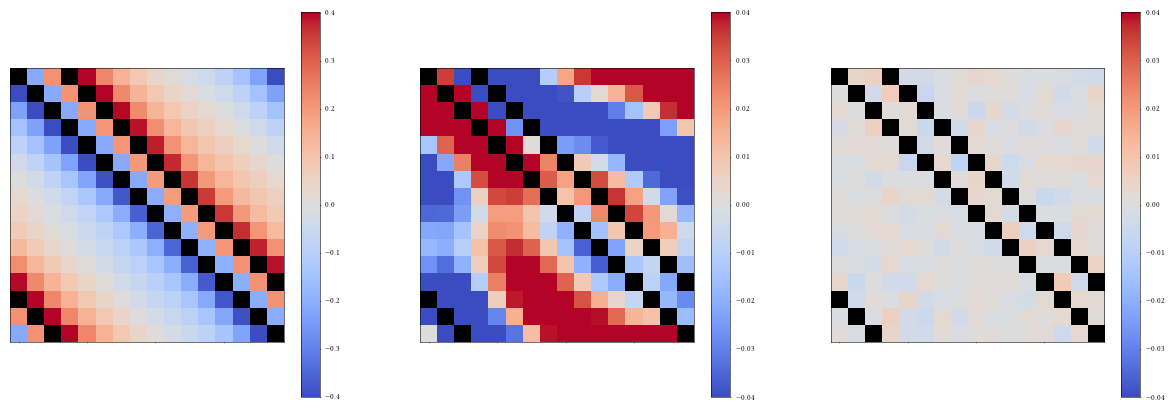

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
electrode_nums = np.arange(16)
objectives = ref1
iter_first = record1["primals-0"]
iter_last =  record1["primals-128"]
im1 = visualize_primal(objectives, ax1)
plt.colorbar(im1)
im2 = visualize_primal(iter_first - objectives, ax2, input_range = [-0.04, 0.04])
plt.colorbar(im2)
im3 = visualize_primal(iter_last - objectives, ax3, input_range = [-0.04, 0.04])
plt.colorbar(im3)

In [12]:

def plot_shape(record, ax, iternum):
    out_radius =1 
    bbox_plot = [[-1.1 * out_radius,-1.1 * out_radius],[1.1 * out_radius, 1.1 * out_radius]]
    out_shape = CircleWithElectrodes(is_delta = True)

    obj_radius = record["radius-obj"]
    obj_origin = record["origin-obj"]
    iter_radius= record[f"inboundary.dirichlet.radius-{iternum}"]
    iter_origin= record[f"inboundary.dirichlet.origin-{iternum}"]
    in_shape_obj = CircleShape(obj_origin, obj_radius)
    in_shape = CircleShape(iter_origin, iter_radius)
    
    image = in_shape_obj.sketch_image(ax, bbox = bbox_plot, resolution = resolution_plot, channel = 0)
    image = in_shape.sketch_image(ax, bbox = bbox_plot, resolution = resolution_plot, image = image, channel = 2)
    black_region = image.sum(axis = 2) < 0.1
    image[black_region]  = 1
    ax.imshow(image)
    ax.axis("on")
    out_shape.sketch(ax, bbox = bbox_plot, resolution = resolution_plot, lw = linewidth, e_size= e_size)
    disable_ticks(ax)
    disable_border(ax)


Text(0.5, 1.0, 'a')

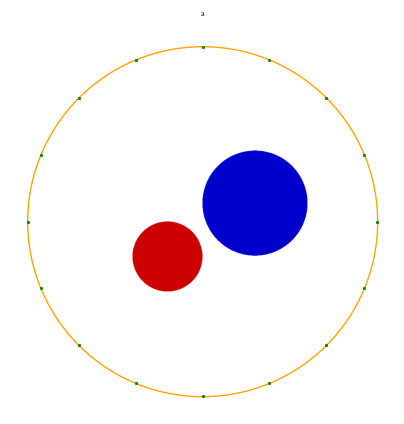

In [13]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
plot_shape(record1, ax, 2)
ax.set_title("a", pad = 10)

In [14]:

def vis_single_opt(fig, ax, record, objectives, iters, cbar_offset, pre_cbar_offset, post_cbar_offset, pre_image_offset, image_shrink, cbar_begin, cbar_end, imsize,   num_ticks = 3, 
                   verbose = False, verbose_last =False):
    total_cbar_offset = cbar_offset + pre_cbar_offset + post_cbar_offset
    num_iter = len(iters)
    num_images = num_iter + 3
    title_pad = 3
    title_pad2 = 1.3
    g = gridspec.GridSpecFromSubplotSpec(imsize, imsize * num_images + total_cbar_offset * 2 + 1 * pre_image_offset, ax.get_subplotspec(), wspace = 0.0, hspace=0.0)

    for i, iter in enumerate(iters):
        ax = fig.add_subplot(g[0 : imsize, i * imsize : (i+1) * imsize])

        plot_shape(record, ax, iter)
        if verbose:
            text = f"(a{i+1})"
            t = r"$\textbf{" + text + "}$"
            ax.set_title(f"{t} Iter. {iter}", pad = title_pad)

    offset = imsize * num_iter
    primal_objective = objectives[-16:]
    primal_begin = record["primals-0"][-16:] - primal_objective
    primal_end = record[f"primals-{iters[-1]}"][-16:] - primal_objective

    primal_objective =primal_objective
    primal_begin = primal_begin
    primal_end =  primal_end
    
    ax_primal_objective = fig.add_subplot(g[image_shrink : imsize-image_shrink, offset + image_shrink : offset + imsize - image_shrink])
    im_primal_objective = visualize_primal(primal_objective, ax_primal_objective, input_range = [None, None], verbose_x = verbose_last, verbose_y = True)
    if verbose:
        ax_primal_objective.set_title(r"$\textbf{(b)}$ $u_{\mathrm{ref}}$", pad = title_pad + title_pad2)

    
    offset += imsize
    ax_cbar_primal_obj = fig.add_subplot(g[cbar_begin : imsize-cbar_end, pre_cbar_offset + offset : 
                                                    pre_cbar_offset + offset + cbar_offset])
    cbar_primal_obj = plt.colorbar(im_primal_objective, cax = ax_cbar_primal_obj)
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    cbar_primal_obj.locator = tick_locator
    cbar_primal_obj.formatter.set_powerlimits((0, 0))
    cbar_primal_obj.ax.yaxis.set_offset_position('left') 
    cbar_primal_obj.update_ticks()
    offset += total_cbar_offset #+ pre_image_offset

    maxdiff = max(np.max(primal_begin), np.max(primal_end))
    mindiff = min(np.min(primal_begin), np.min(primal_end))
    max_range = max(maxdiff, -mindiff)
    input_range_diff = [-max_range, max_range]
    
    ax_primal_begin = fig.add_subplot(g[image_shrink : imsize - image_shrink, offset + image_shrink : offset + imsize - image_shrink])
    im_primal_begin = visualize_primal(primal_begin, ax_primal_begin, input_range = input_range_diff, verbose_x = verbose_last, verbose_y = False)
    if verbose:
        ax_primal_begin.set_title(r"$\textbf{(c1)}$ $u_0 - u_{\mathrm{ref}}$", pad = title_pad + title_pad2)
    offset += imsize #+ pre_image_offset

    ax_primal_end = fig.add_subplot(g[image_shrink : imsize - image_shrink, offset + image_shrink : offset + imsize - image_shrink])
    im_primal_end = visualize_primal(primal_end, ax_primal_end, input_range = input_range_diff, verbose_x = verbose_last, verbose_y = False)
    if verbose:
        ax_primal_end.set_title(r"$\textbf{(c2)}$ $u_{\mathrm{last}} - u_{\mathrm{ref}}$", pad = title_pad + title_pad2)
    offset += imsize #+ pre_image_offset

    ax_cbar_primal = fig.add_subplot(g[cbar_begin : imsize-cbar_end, pre_cbar_offset + offset : 
                                                    pre_cbar_offset + offset + cbar_offset])
    cbar_primal = plt.colorbar(im_primal_begin, cax = ax_cbar_primal)
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    cbar_primal.locator = tick_locator
    cbar_primal.formatter.set_powerlimits((0, 0))
    cbar_primal.ax.yaxis.set_offset_position('left') 
    cbar_primal.update_ticks()


In [15]:
records = [record1, record2, record3, record4]

GPL Ghostscript 9.55.0: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.
GPL Ghostscript 9.55.0: Can't embed the complete font LinBiolinumTB as it is too large, embedding a subset.
GPL Ghostscript 9.55.0: Can't embed the complete font LinLibertineT as it is too large, embedding a subset.


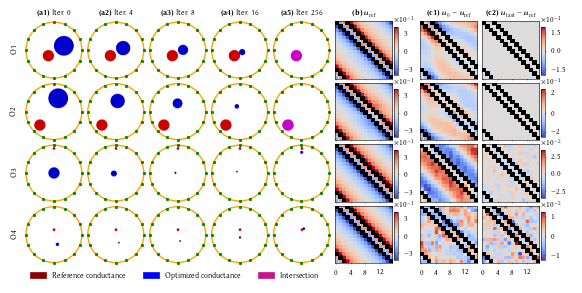

In [16]:
cbar_offset = 2
pre_cbar_offset = 0
post_cbar_offset = 10
total_cbar_offset = cbar_offset + pre_cbar_offset + post_cbar_offset
cbar_begin = 4
cbar_end = 3
imsize = 32
iters = [0, 4, 8, 16, 256]
num_images = len(iters) + 3
pre_image_offset = 4
image_shrink = 1
end = 1
scale = (num_images * imsize + 2 * total_cbar_offset + 1 * pre_image_offset) / TEXT_WIDTH
num_opt = len(records)
fig = plt.figure(figsize = ((num_images * imsize + 2 * total_cbar_offset + 1 * pre_image_offset) / scale, (num_opt * imsize + end) / scale))


g = gridspec.GridSpec(num_opt * imsize + end, 1, figure = fig, wspace =0, hspace=0)
for i, (record, ref) in enumerate(zip(records, refs)):
    ax = fig.add_subplot(g[i*imsize : (i+1) * imsize])
    ax.set_ylabel(f"O{i + 1}")
    disable_border(ax)
    disable_ticks(ax)
    verbose = (i ==0)
    verbose_last = i == len(records)-1

    vis_single_opt(fig, ax, record, ref, iters, cbar_offset, pre_cbar_offset, post_cbar_offset, pre_image_offset, image_shrink, cbar_begin, cbar_end, imsize,  num_ticks = 3, 
                   verbose = verbose, verbose_last = verbose_last) 



ax_legend =fig.add_subplot(g[-end:])
ax_legend.axis("off")
red_patch = mpatches.Patch(color='darkred', label='Reference conductance')
blue_patch = mpatches.Patch(color='blue', label='Optimized conductance')
magenta_patch = mpatches.Patch(color='mediumvioletred', label='Intersection')
ax_legend.legend(handles=[red_patch, blue_patch, magenta_patch], loc = "upper left", ncol = 3, frameon = False)
save_fig("opt-discrete-circle", os.path.join(PATH, "figures"))
plt.savefig(os.path.join(PATH, "figures", "png", "opt-discrete-circle.png"), bbox_inches='tight', pad_inches=0.04, dpi=1000)
